## Imports 

In [1]:
import numpy as np 
import sympy.geometry as sp
from time import clock 

## Creating Sympy polygons

In [2]:
p1, p2, p3, p4 = [(0, 5), (0, 0), (5, 0), (5, 5)]
p5, p6, p7, p8 = [(1, 3), (1, 1), (3, 1), (3,3)]
pol1 = sp.Polygon(p1, p2, p3, p4)
pol2 = sp.Polygon(p5, p6, p7, p8)

r = pol1.intersection(pol2)
#polr = sp.Polygon(*r)
print(r)

[]


## Sort polygon points counter-clockwise order

In [3]:
def less(a, b, center):
    
    if a[0] - center[0] >= 0 and b[0] - center[0] < 0:
        return 1
    if a[0] - center[0] < 0 and b[0] - center[0] >= 0:
        return -1
    if a[0] - center[0] == 0 and b[0] - center[0] == 0:
        if a[1] - center[1] >= 0 or b[1] - center[1] >=0:
            return a[1] - b[1]
        return b[1] - a[1]
    
    # Compute cross product of vectors a and b 
    cross = np.cross(a-center, b-center)
    if cross < 0:
        return 1
    if cross > 0:
        return -1
    
    # Points are in the same line from the center
    # Check which is closer 
    d1 = np.sum((a-center)**2)
    d2 = np.sum((b-center)**2)
    return d1 - d2

def cmp_to_key(mycmp, center):
    'Convert a cmp= function into a key= function'
    class K:
        def __init__(self, obj, *args):
            self.obj = obj
        def __lt__(self, other):
            return mycmp(self.obj, other.obj, center) < 0
        def __gt__(self, other):
            return mycmp(self.obj, other.obj, center) > 0
        def __eq__(self, other):
            return mycmp(self.obj, other.obj, center) == 0
        def __le__(self, other):
            return mycmp(self.obj, other.obj, center) <= 0
        def __ge__(self, other):
            return mycmp(self.obj, other.obj, center) >= 0
        def __ne__(self, other):
            return mycmp(self.obj, other.obj, center) != 0
    return K
    
def counter_clockwise(points):
    n = len(points)
    center = np.sum(points, axis=0)/n
    points = list(points)
    points.sort(key=cmp_to_key(less, center))
    return np.array(points) 

## Check if polygon is convex  -- Gift Wrapper

In [15]:
def is_ccw(p1, p2, p3):  # Is CounterClockwise 
    # Checking if slope of p1p2 is less than slope of p2p3
    s1 = (p2[1] - p1[1]) * (p3[0] - p2[0])
    s2 = (p3[1] - p2[1]) * (p2[0] - p1[0]) 
    if s1 <= s2:
        return True
    else:
        return False 

def gift_wrapper(np_points):
    
    # Number of points
    n = len(np_points)
    
    # Find leftmost point 
    i0 = np.argmin(np_points, axis=0)[0]
    point_on_hull = np_points[i0]
    
    # Creating Hull and its iterator 
    i = i0
    H = []
    
    # Build the Hull until back to the first point 
    while True:
        
        # Adding point in the Hull 
        H.append(np_points[i])
        
        # k stores the point of smallest angle (ccw of all others), inicializing here 
        k = (i+1)%n
        
        # Loop on all the other points 
        for j in (x for x in range(n) if x != i):
            if is_ccw(np_points[i], np_points[j], np_points[k]):  # If there is a point j more cck than the current, change
                k = j 
        i = k
        
        if (i == i0):
            break
    
    return np.array(H)

## Implementation in python

In [68]:
# SegSegInt: Finds the point of intersection p between two closed
# segments ab and cd.  Returns p and a char with the following meaning:
#   'e': The segments collinearly overlap, sharing a point.
#   'v': An endpoint (vertex) of one segment is on the other segment,
#        but 'e' doesn't hold.
#   '1': The segments intersect properly (i.e., they share a point and
#        neither 'v' nor 'e' holds).
#   '0': The segments do not intersect (i.e., they share no points).
# Note that two collinear segments that share just one point, an endpoint
# of each, returns 'e' rather than 'v' as one might expect.

def segsegint(a1, a, b1, b):
    # For math reference see https://stackoverflow.com/questions/563198/whats-the-most-efficent-way-to-calculate-where-two-line-segments-intersect
    # segment1 = (p, p+r) =  p + t*r 
    # segment2 = (q, q+s) =  q + u*s , parametric form

    # Line intersects if there is t and u, so that 
    # p + t*r = q + u*s
    # Or, using cross product with pt2
    # t*(r X s) = (q - p) X s
    
    code = '?'
    p = a1
    q = b1
    r = (a - a1)
    s = (b - b1)
    r_cross_s = np.cross(r, s) 
    
    if r_cross_s == 0:
        if np.cross(q-p, r) == 0:
            # Segments are colinear
            code = 'e'
            seg = return_overlapping(p, q, r, s)
            return code, seg[0], seg[1]
            
        else:
            # Segments are parallel and non-intersecting
            code = 0
            return code, None, None

    t = np.cross(q-p, s) / r_cross_s
    u = np.cross(q-p, r) / r_cross_s

    if (0 <= t <= 1) and (0 <= u <= 1):
        #Segments intersect in one point
        if t==0 or t==1 or u==0 or u==1:
            code = 'v'
        else:
            code = 1
        return code, p + t*r, None
    else:
        # Segments do not intersect 
        code = 0
        return code, None, None
    
def return_overlapping(p,q,r,s):
    
    t0 = np.dot(q-p,r)/np.dot(r,r)
    t1 = np.dot(q+s-p,r)/np.dot(r,r)
    seg = []
    
    if (np.dot(s,r) >= 0):
        
        if t1 < 0 or t0 > 1:
            return [None, None]
        elif t1 == 0:
            return (p, None)
        elif t0 == 1:
            return (p+r, None)
        if (0 < t0 < 1):
            seg.append(p+t0*r)
        elif t0 <= 0: 
            seg.append(p) 
        if (0 < t1 < 1):
            seg.append(p+t1*r)
        elif t1 >= 1: 
            seg.append(p+r)
            

    elif (np.dot(s,r) < 0):
        if t0 < 0 or t1 > 1:
            return [None, None]
        elif t0 == 0:
            return (p, None)
        elif t1 == 1:
            return (p+r, None)
        if (0 < t1 < 1):
            seg.append(p+t1*r)
        elif t1 <= 0: 
            seg.append(p) 
        if (0 < t0 < 1):
            seg.append(p+t0*r)        
        elif t0 >= 1:
            seg.append(p+r)
                    
    return seg
    

In [17]:
def inout(p, inflag, aHB, bHA):
    #Add point
    I.append(p)
    
    # Update inflag
    if aHB > 0:
        return 'Pin'
    elif bHA > 0:
        return 'Qin'
    else:     #Keep status quo
        return inflag

In [18]:
def advance(a, aa, n, inside, v):
    if inside:
        # Add point
        #I.append(v)
        #print("Found point {} of polygon!".format(v))
        pass
    aa += 1
    return (a+1) % n, aa

In [19]:
def area_sign(o, a, b):
    '''
    Verify if the cross product of
    oa X ob is positive, negative or zero
    o stands of origin, a and b are vectors
    '''
    A = a - o 
    B = b - o 
    area = np.cross(A, B)
    
    if area > 0:
        return 1 
    elif area < 0:
        return -1
    else:
        return 0 

In [57]:
def convex_intersect(P, Q):
    
    # Inicializing variables
    a, b = 0, 0              # Indices of P and Q respectivaly
    aa, ba, = 0, 0           # Advvances on a and b
    n, m = len(P), len(Q)    # Number of vertices of polygons
    inflag = 'Unknow'        # Which polygon is 'inside' 
    FirstPoint = True 
    global i 
    i = 0 #test
    global I 
    I = []  # The intersection polygon
    
    # Main loop
    while ((aa < n) or (ba < m)) and (aa < 2*n) and (ba < 2*m) :   #If both looped or one looped twice through polygon
        i += 1
        # a-1 and b-1, respectivaly 
        a1 = (a + n - 1) % n
        b1 = (b + m - 1) % m 
        
        # A and B are the subvectors that describe a1 to a (the edge of polygon)
        A = P[a] - P[a1]
        B = Q[b] - Q[b1]
      
        # Cheching cross products to predict advance
        origin = np.array([0, 0])
        cross = area_sign(origin, A, B)
        aHB = area_sign(Q[b1], Q[b], P[a])  # a is in the halfplane to the left of B
        bHA = area_sign(P[a1], P[a], Q[b])  # b is in the halfplane to the left of A
        #print("Cross", cross)
        
        # If A and B intersect, change the inflag 
        # code is the kind of intersection, p and q are the intersetion points, if exists
        code, p, q = segsegint(P[a1], P[a], Q[b1], Q[b])
        if code == 1 or code =='v':
            if inflag == 'Unknow' and FirstPoint:
                aa, ab = 0, 0 
                FirstPoint = False 
                p0 = p    # p0 is the first point
                #I.append(p0)
            inflag = inout(p, inflag, aHB, bHA)
        
        # ADVANCE RULES
        
        # Special case: A & B overlap and oppositely oriented
        if code == 'e' and np.dot(A, B) < 0:
            #raise SystemExit
            print("Special case interception")
            return[]
        
        # Special case: A & B parallel and separated
        if cross == 0 and aHB < 0 and bHA < 0:
            print("P and Q are disjoint")
            #raise SystemExit
            return []
        
        # Special case: A & B are collinear
        elif cross == 0 and aHB == 0 and bHA == 0:
            if inflag == 'Pin':
                b, ba = advance(b, ba, m, inflag=='Qin', Q[b])
            else:
                a, aa = advance(a, aa, n, inflag=='Pin', P[a])
        
        # Generic cases
        elif cross >= 0:
            if bHA > 0:
                a, aa = advance(a, aa, n, inflag=='Pin', P[a])
            else:
                b, ba = advance(b, ba, m, inflag=='Qin', Q[b])
        
        else:  # cross<0
            if aHB > 0:
                b, ba = advance(b, ba, m, inflag=='Qin', Q[b])
            else:
                a, aa = advance(a, aa, n, inflag=='Pin', P[a])
                
    if not FirstPoint:  # If found at least one point
        # I.append(p0)
        pass
        
    if inflag == "Unknow":
        print("The boundaries of P and Q do not cross")
    
    return(I)

In [58]:
P = np.array(([1, 0], [0, 0], [0, 1], [5, 1]))
Q = np.array([(0, 2), (1, -1), (3, 2)])

R = convex_intersect(gift_wrapper(P), gift_wrapper(Q))
print(R)

[array([0.66666667, 0.        ]), array([1.8, 0.2]), array([2.33333333, 1.        ]), array([0.33333333, 1.        ])]


In [59]:
pol1 = sp.Polygon(*P)
pol2 = sp.Polygon(*Q)
r = sp.intersection(pol2, pol1)
print(r)

[Point2D(1/3, 1), Point2D(2/3, 0), Point2D(9/5, 1/5), Point2D(7/3, 1)]


## Calculating Polygon Area 

In [23]:
def polygon_area(np_points):
    n = len(np_points)
    area = 0 
    origin = np_points[0]
    for i in range(n-1):
        if i == 0:
            continue 
        j = i + 1
        
        #Triangle vectors 
        A = np_points[i] - origin
        B = np_points[j] - origin 
        
        area += np.cross(A, B)/2
    
    return area
        

In [24]:
print(pol1.area)
print(pol2.area)

-3
9/2


In [25]:
print(polygon_area(P))
print(polygon_area(Q))

-3.0
4.5


In [114]:
print(polygons[0])

i = 0 
P = [points[10*i + j] for j in range(10)]
P = gift_wrapper(P)
print(P)

print("\n")

print(polygons2[0])

i = 0 
Q = [points2[10*i + j] for j in range(10)]
Q = gift_wrapper(Q)
print(Q)

sympy_list = sp.intersection(polygons[0], polygons2[0])
print(sympy_list)
convex_intersect(P, Q)

lista = []
for point in convex_intersect(P, Q):
    lista.append(sp.Point(point))
print(lista[0])
sympy_list[0]
np.isclose(lista[0], sympy_list[0])

Polygon(Point2D(130177301094631/1000000000000, 113672739627473/200000000000), Point2D(50501633410869/200000000000, 65796651296089/250000000000), Point2D(18286704502793/50000000000, 24440510701389/125000000000), Point2D(937997411128899/1000000000000, 641197642558083/1000000000000), Point2D(901016482618323/1000000000000, 757033028185171/1000000000000), Point2D(203974974845081/250000000000, 233317898394667/250000000000), Point2D(195378120450107/1000000000000, 92421119863817/100000000000))
[[130.17730109 568.36369814]
 [252.50816705 263.18660518]
 [365.73409006 195.52408561]
 [937.99741113 641.19764256]
 [901.01648262 757.03302819]
 [815.89989938 933.27159358]
 [195.37812045 924.21119864]]


Polygon(Point2D(67201386616139/50000000000000, 402871505003313/500000000000), Point2D(917612483627529/10000000000000, 427110900402733/1000000000000), Point2D(21887630314819/31250000000, 9621577236833/40000000000), Point2D(897775422742991/1000000000000, 141808992614957/500000000000), Point2D(40326050152

## Time on sympy polygons

In [160]:
number_of_polygons = 200

points = 1000 * np.random.random_sample([10*number_of_polygons, 2])
points2 = 1000 * np.random.random_sample([10*number_of_polygons, 2])

polygons = []
polygons2 = []
for i in range(number_of_polygons):
    arr = [points[10*i + j] for j in range(10)]
    arr = gift_wrapper(arr)
    polygons.append(sp.Polygon(*arr))
    
    arr2 = [points2[10*i + j] for j in range(10)]
    arr2 = gift_wrapper(arr2)
    polygons2.append(sp.Polygon(*arr2))


In [161]:
intersections = []

inicial_time = clock()
for i in range(number_of_polygons):
    intersections.append(sp.intersection(polygons[i], polygons2[i]))
final_time = clock()

print("Time spent on sympy", final_time - inicial_time)



Time spent on sympy 711.6030369209184


In [162]:
np_intersections = []

inicial_time = clock()
for i in range(number_of_polygons):
    P = [points[10*i + j] for j in range(10)]
    P = gift_wrapper(P)
    Q = [points2[10*i + j] for j in range(10)]
    Q = gift_wrapper(Q)
    np_intersections.append(convex_intersect(P,Q))
final_time = clock()

print("Time spent now", final_time - inicial_time)

The boundaries of P and Q do not cross
The boundaries of P and Q do not cross
Time spent now 0.7064752248688819


In [163]:
#print(len(intersections[0]))
#print(len(np_intersections[0]))

for i in range(number_of_polygons):
    if len(intersections[i]) != len(np_intersections[i]):
        print("Something wrong in {}, please check!".format(i))
    else:
        #print("great job")

great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job
great job


6
6
[Point2D(26471804805399801684511900573065008472556373/74557656081843761861806378226500000000000, 3127101604314203772557825112354902205941713/18639414020460940465451594556625000000000), Point2D(35872630828291509072015636156681257733654737/89441103775682525125731873826000000000000, 9915335844745383098041402088643814828737341/11180137971960315640716484228250000000000), Point2D(3970842925972911939036473377492013036016439/7177009765558736030082729497000000000000, 199674374783278270378079588039954241061363/224281555173710500940085296781250000000), Point2D(8238941013117137433323581097210714388536069/9379647458725363442660083545000000000000, 1179543024343436208084166410640857963075773/1563274576454227240443347257500000000000), Point2D(54929846869782394405048779528389094889936239/61796723998451785413653304209000000000000, 325837460564639037628028189787455881567491/965573812475809147088332878265625000000), Point2D(85662382213945739297080178198669503588951241/918620650155055519469933445030000

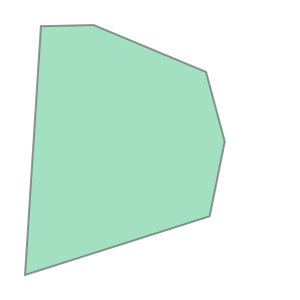

In [201]:
print(len(intersections[0]))
print(len(np_intersections[0]))

print(intersections[0])
np_intersections[0]

#pol = sp.Polygon(*intersections[0])
pol = sp.Polygon(*np_intersections[0])
pol 

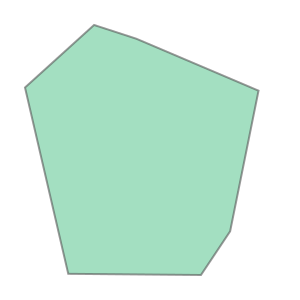

In [178]:
i = 0
sp.Polygon(*gift_wrapper([points[10*i + j] for j in range(10)]))


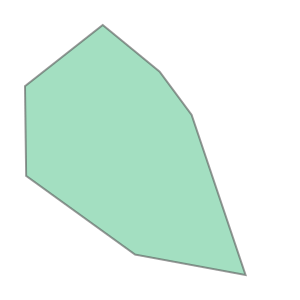

In [171]:
sp.Polygon(*gift_wrapper([points2[10*i + j] for j in range(10)]))

## Checking time for calculating areas 

In [207]:
area = []
np_area = []

inicial_time = clock()
for pol in intersections:
    if len(pol) < 3:
        #print("Not polygon in ", i)
        continue
    pol = gift_wrapper(pol)
    pol = sp.Polygon(*pol)
    area.append(pol.area)
final_time = clock()

print("Time spent in sympy area is ", final_time - inicial_time)

Time spent in sympy area is  1.9905603876031819


In [208]:
inicial_time = clock()
for pol in np_intersections:
    if len(pol) < 3:
        #print("Not polygon in ", i)
        continue
    pol = gift_wrapper(pol)
    np_area.append(polygon_area(pol))
final_time = clock()

print("Time spent in area now", final_time - inicial_time)



Time spent in area now 0.038475882252896554


In [252]:
for i in range(len(np_area)):
    if not np.isclose(np_area[i], np.array(area[i], dtype=np.float64)):
        print("Check ", i)